In [48]:
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

custom_palette = {
    0: 'red',
    0.1: 'lightblue',
    0.5: 'lightblue',
    1: 'dodgerblue',
    2: 'royalblue',
    4: 'blue',
    16: 'navy',
    32: 'darkblue',
    64: 'midnightblue',
    'DISCREPANCY': sns.color_palette('Set2')[0],  # Default Seaborn palette color for 'DISCREPANCY'
    'ENTROPY': sns.color_palette('Set2')[1],  # Default Seaborn palette color for 'ENTROPY'
    'NegCE': sns.color_palette('Set2')[2],  # Default Seaborn palette color for 'NegCE'
    'DBAT': sns.color_palette('Set2')[3],  # Default Seaborn palette color for 'DBAT'
    'DANN': sns.color_palette('Set2')[0],  # Default Seaborn palette color for 'DBAT'
    'ERM': sns.color_palette('Set2')[1],  # Default Seaborn palette color for 'DBAT'
}

N_SAMPLES = 1000
tag = 'uda_cam_exp'
df_path = f'dfs/{tag}.pk'

try:
    df = pd.read_pickle(df_path)
except:
    df = pd.DataFrame()

r_dfs = []
runs = wandb.Api().runs('mila-projects/domainbed', filters={'tags': tag, 'state': 'finished'})

for r in runs:
    config = r.config
    run_id = config['run_id']
    tags_str = '/'.join(r.tags)
    config['tags'] = tags_str
    if 'run_id' in df.columns and df.run_id.str.contains(run_id).any():
        continue
    r_df = r.history(samples=N_SAMPLES)
    print(run_id)
    assert r_df.step.max() == 10000
    for k, v in config.items():
        if isinstance(v, list) and len(v) > 1:
            raise Exception(k, v)
        elif isinstance(v, list):
            v = v[0]
        r_df[k] = v
    df = pd.concat([df, r_df], ignore_index=True)

df.to_pickle(df_path)
df = pd.read_pickle(df_path)

def set_model_name(r):
    data_aug = '' if r['data_augmentation'] else '_NO_DA'
    algorithm = 'ERM' if r['algorithm'] == 'ERM' else r['dann_disc_loss']
    return algorithm + data_aug

## Backfill values
df.loc[df['grad_penalty'].isna(), 'grad_penalty'] = 0.0
df.loc[df['data_augmentation'].isna(), 'data_augmentation'] = True
df['mlp_width'] = df['hparam_mlp_width']
df['mlp_depth'] = df['hparam_mlp_depth']
df['train_acc'] = df['train_in_acc']
df['val_acc'] = df['env0_out_acc']
df['wgan_grad_loss'] = df['grad_penalty_loss']
df.loc[df['algorithm'] == 'ERM', 'dann_disc_loss'] = ''
df['alg_name'] = df['algorithm'] + '_' + df['dann_disc_loss']
df['model_name'] = df.apply(set_model_name, axis=1)
df.rename(columns={'testenv_in_acc': 'test_acc'}, inplace=True)

c7fdaf85-c8fb-497c-a697-89a65f164bf5
788b39f2-2938-4db6-b7fa-3be8997afc8c
39e83a1d-44b1-4a7a-8cb5-a1fbb627d169
fdc38c8f-db28-4122-b300-dc96b01758a6
e3bbe90e-3662-473d-8be4-215303424799
f65ce5cf-3a95-49f6-89c2-108ccbfe0636
9f9184ae-e32e-455c-a0af-d0653174c9af
5ae55277-67bd-4276-8c03-e3a15725db42
d03c420a-e007-4996-98b2-fab1f35b143b
f5f77d9d-7bc9-4f7f-af61-d30ca3187032
35430f96-2a8b-404b-8303-d75d01227d39
cccddfba-56f3-4321-ac0e-d15989acb0a9
af37bb70-eeb9-4ed2-aba7-f26a2ac5c820
88ae5ce2-bc70-4455-a079-c58a0d8508b7
30f25e0e-7bcf-4298-8be0-e50cbc35667f
bd101f20-bca1-49a4-9076-60372b65d892


In [44]:
def plot_facet_grid(df, hue, y, row=None, col=None, x='step', melt_metrics=None, palette=custom_palette, title=None, plot_args={}, **grid_kwargs):
    if melt_metrics is not None:
        id_vars = ['step', 'dann_disc_loss', 'dann_lambda', 'data_augmentation']
        if hue not in id_vars:
            id_vars.append(hue)
        df = df.melt(id_vars=id_vars, var_name='metric', value_name='value')
        df = df[df['metric'].isin(melt_metrics)]
        df['metric'] = pd.Categorical(df['metric'], melt_metrics)
        df = df.sort_values('metric')
    g = sns.FacetGrid(df, col=col, row=row, sharey=False, **grid_kwargs)
    g.map_dataframe(sns.lineplot, x=x, y=y, hue=hue, palette=palette, legend='full', **plot_args)
    prefix = ''
    if col == 'dann_disc_loss':
        prefix = 'loss:'
    elif col == 'dann_lambda':
        prefix = 'λ:'
    g.set_titles(size=10, col_template=prefix + "{col_name}", row_template="{row_name}")
    g.add_legend(title=f'{hue}')
    if title:
        g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
        g.fig.suptitle(title)
    return g

In [7]:
base_metrics = ['train_acc', 'val_acc', 'test_acc', 'disc_acc', 'disc_loss', 'gen_disc_loss', 'wgan_grad_loss', 'classifier_loss']
add_metrics = [
    'disc_acc_d0',
        'disc_acc_d1',
        'disc_acc_d2',
        'disc_n_preds_d0',
        'disc_n_preds_d1',
        'disc_n_preds_d2',
        'disc_prob_mean_d0',
        'disc_prob_mean_d1',
        'disc_prob_mean_d2',
        'env0_out_acc',
        'env1_out_acc',
        'env2_out_acc',
        'env3_out_acc',
        'env4_out_acc'
 ]

### Different Disc Losses

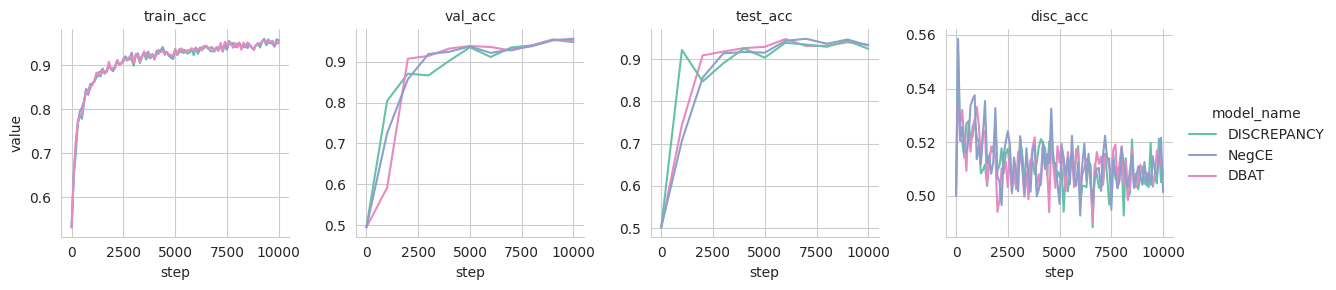

In [68]:
disc_loss_df = df[df['tags'].str.contains('uda_cam_disc_loss')]
plot_facet_grid(disc_loss_df, hue='model_name', y='value', col='metric', melt_metrics=['train_acc', 'val_acc', 'test_acc', 'disc_acc'])

### Probing different lambda for discrepancy loss

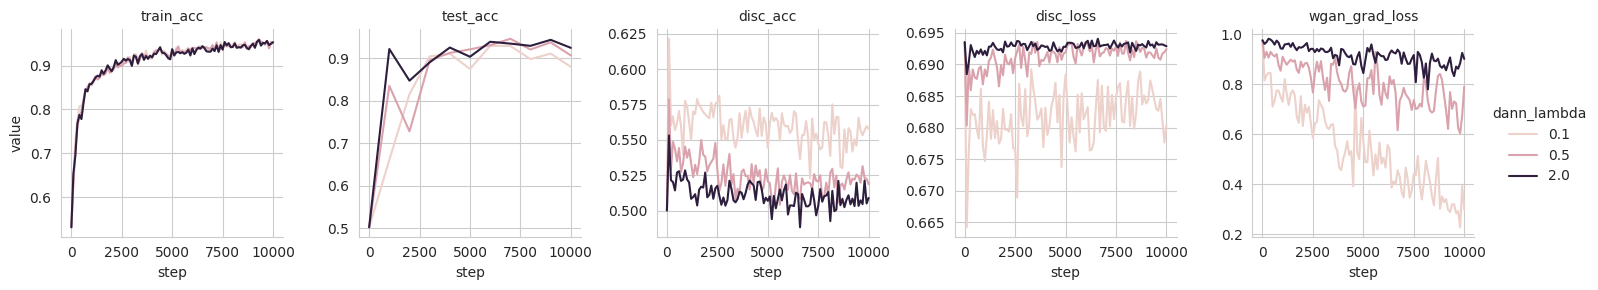

In [26]:
lambda_probe_df = df[df['tags'].str.contains('uda_cam_lambda')]
m = ['train_acc', 'test_acc', 'disc_acc', 'disc_loss', 'wgan_grad_loss']
plot_facet_grid(lambda_probe_df, hue='dann_lambda', y='value', col='metric', palette=None, melt_metrics=m)

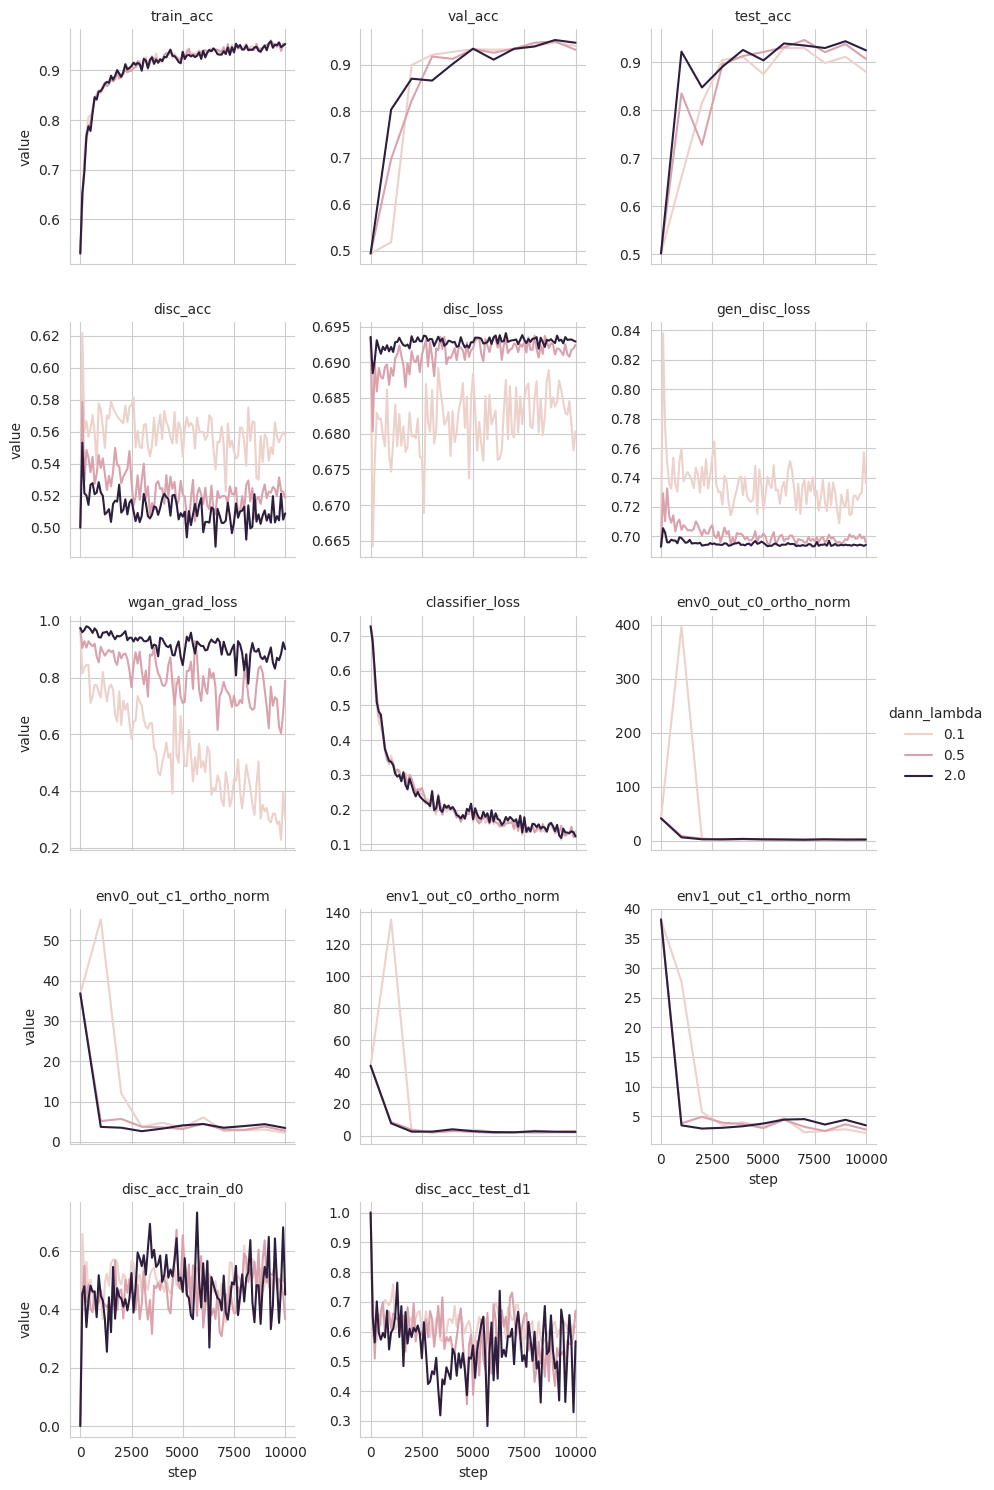

In [66]:
plot_facet_grid(lambda_probe_df, hue='dann_lambda', y='value', col='metric', palette=None, melt_metrics=base_metrics + uda_metrics, col_wrap=3)

In [65]:
uda_metrics = [
    'env0_out_c0_ortho_norm',
    'env0_out_c1_ortho_norm',
    'env1_out_c0_ortho_norm',
    'env1_out_c1_ortho_norm',
    'disc_acc_train_d0',
    'disc_acc_test_d1'
]
sorted(lambda_probe_df.columns)

['_runtime',
 '_step',
 '_timestamp',
 'alg_name',
 'algorithm',
 'checkpoint_freq',
 'classifier_loss',
 'dann_disc_loss',
 'dann_lambda',
 'data_augmentation',
 'data_dir',
 'dataset',
 'disc_acc',
 'disc_acc_test_d1',
 'disc_acc_train_d0',
 'disc_loss',
 'disc_loss_test_d1',
 'disc_loss_train_d0',
 'disc_loss_w_gp',
 'disc_n_preds_test_d1',
 'disc_n_preds_train_d0',
 'disc_params',
 'disc_prob_mean_test_d1',
 'disc_prob_mean_train_d0',
 'disc_prob_std_test_d1',
 'disc_prob_std_train_d0',
 'env0_out_acc',
 'env0_out_c0_ortho_norm',
 'env0_out_c1_ortho_norm',
 'env0_uda_acc',
 'env1_in_acc',
 'env1_out_acc',
 'env1_out_c0_ortho_norm',
 'env1_out_c1_ortho_norm',
 'epoch',
 'feat_params',
 'gen_disc_loss',
 'gen_disc_loss_w_gp',
 'gen_loss',
 'grad_penalty',
 'grad_penalty_loss',
 'holdout_fraction',
 'hparam_batch_size',
 'hparam_beta1',
 'hparam_class_balanced',
 'hparam_d_steps_per_g_step',
 'hparam_dann_disc_loss',
 'hparam_dann_lambda',
 'hparam_data_augmentation',
 'hparam_grad_pe

### DA vs No DA

/tmp/ipykernel_19867/1168475528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_df['train_acc'] = da_df['env0_out_acc'] + 0.01


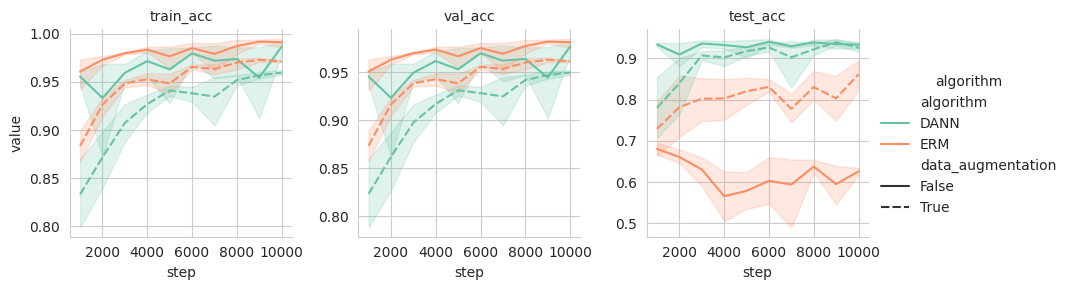

In [53]:
da_df = df[df['tags'].str.contains('uda_cam_da')]
da_df['train_acc'] = da_df['env0_out_acc'] + 0.01
plot_facet_grid(da_df.query('step > 500'), hue='algorithm', y='value', col='metric', melt_metrics=['train_acc', 'val_acc', 'test_acc'], plot_args={'style': 'data_augmentation'})

In [56]:

epoch_max_indices = da_df.groupby(by='run_id')['val_acc'].idxmax()

da_df.loc[epoch_max_indices]\
    .groupby(by=['algorithm', 'data_augmentation'], as_index=False)\
    .agg(['mean', 'std'])\
    .filter(regex='algorithm|val_acc|test_acc')\
    .style.format(precision=3)
    # .filter(regex='run_id|dann_|acc_avg')


/tmp/ipykernel_19867/1223205609.py:3: FutureWarning: ['task', 'run_id', 'dataset', 'hparams', 'data_dir', 'output_dir', 'wandb_log_dir', 'dann_disc_loss', 'hparam_dann_disc_loss', 'tags', 'alg_name', 'model_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  da_df.loc[epoch_max_indices]\
